#Training a Neural Network in PyTorch#

PyTorch is a powerful, widely-used machine learning library. It has all the latest neural network layers and functions and supports GPU computation.

Most neural network research these days either happens in PyTorch or TensorFlow. Google Research develops TensorFlow while Facebook AI Research develops PyTorch. Functionally they are probably very similar, I just know a lot of people who use PyTorch and it seems like it might be somewhat easier for beginners to learn. It is important to have some experience in one of these two frameworks but if you understand the ideas and concepts you shouldn't have too much trouble moving between them.

The `torch` library provides the basic functions we need when dealing with `tensors`. `tensors` are a generalization of matrices to arbirtrary numbers of dimensions (a matrix is a 2D tensor). Types of tensors:


*   0 dimensional: Scalar
*   1 dimensional: Array
*   2 dimensional: Matrix
*   3 dimensional: Number cubey thingy
*   4 dimensional: ?????

Anywho, let's start with our opening chant to invoke the power of PyTorch to aid us. The last line is a special call to the GPU gods to smile on our endeavor.


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


##Time For Some Data##

PyTorch has some built tools for downloading and loading common datasets. We'll be playing around with MNIST in this example. It is a dataset of 28x28 grayscale handwritten digits 0-9. There are 50,000 images in the training set and 10,000 in the test set.



In [3]:
def get_mnist_data():
  trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True,
                                        transform=transforms.ToTensor())
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True,
                                            num_workers=8)

  testset = torchvision.datasets.MNIST(root='./data', train=False, download=True,
                                      transform=transforms.ToTensor())
  testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False,
                                          num_workers=8)
  classes = range(10)
  return {'train': trainloader, 'test': testloader, 'classes': classes}

data = get_mnist_data()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid poten

###Understanding Our Data ###
It's worthwhile to check out how our dataloader loads the images into tensors. We can print out the size of the loaded data in the `images` tensors.



In [4]:
# get some random training images
dataiter = iter(data['train'])
images, labels = dataiter.next()
print(images.size())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([32, 1, 28, 28])


Our `images` tensor is 4-dimensional, (32 x 1 x 28 x 28)

PyTorch stores image data in (N x C x H x W) format. Thus the size of this tensor implies we have a mini-batch of 32 images, each have a single channel (grayscale), and each image is 28 x 28, so that makes sense!

We can use matplotlib to see what our data looks like:

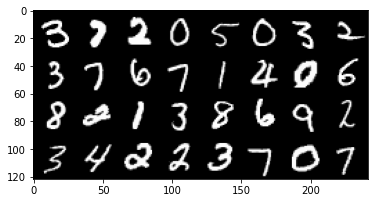

        3         7         2         0


In [5]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%9s' % data['classes'][labels[j]] for j in range(4)))


##A Simple Network##

First we'll build a very basic neural network with a single hidden layer of neurons. This means one fully connected layer of weights connects the input to the hidden neurons and one fully connected layer connects the hidden neurons to the output. We'll use the RELU activation function on the hidden neuron values as our nonlinearity.

These fully connected (or `nn.Linear`) layers expect a 2D input tensor where that is N x I where N is the number of data points in a mini batch and I is the number of inputs. However, our data is formatted in (N x C x H x W) right now so we need to tell PyTorch to rearrange it using `torch.flatten`.

After being `flatten`ed our data goes from (32 x 1 x 28 x 28) to being (32 x 784)

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class SimpleNet(nn.Module):
    def __init__(self, inputs=28*28, hidden=512, outputs=10):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(inputs, hidden)
        self.fc2 = nn.Linear(hidden, outputs)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

###The Training Function ###

Now for training our network. Our `train` function takes as input the `net` to train and the `dataloader` for the training data. It also takes some optional parameters to control training.

For our network we'll be using PyTorch's built in `nn.CrossEntropyLoss`. This will apply a softmax to our network's output, calculate the log-probability assigned to each class, then try to minimize the negative log likelihood of our data (AKA maximize the likelihood)

For our optimizer we are using stochastic gradient descent with learning rate, momentum, and decay parameters.

In [7]:
import torch.optim as optim

def train(net, dataloader, epochs=1, lr=0.01, momentum=0.9, decay=0.0, verbose=1):
  net.to(device)
  losses = []
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
  for epoch in range(epochs):
    sum_loss = 0.0
    for i, batch in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch[0].to(device), batch[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        losses.append(loss.item())
        sum_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            if verbose:
              print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, sum_loss / 100))
            sum_loss = 0.0
  return losses

###Training The Network###

We'll instantiate a new network and train it on our training data.

Our training function prints out some debug information about the epoch, batch number, and current loss values. It also returns a list of all the losses on our mini-batches so we can plot them all once training has finished.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[1,   100] loss: 1.359
[1,   200] loss: 0.503
[1,   300] loss: 0.428
[1,   400] loss: 0.374
[1,   500] loss: 0.344
[1,   600] loss: 0.322
[1,   700] loss: 0.296
[1,   800] loss: 0.293
[1,   900] loss: 0.277
[1,  1000] loss: 0.284
[1,  1100] loss: 0.257
[1,  1200] loss: 0.239
[1,  1300] loss: 0.231
[1,  1400] loss: 0.229
[1,  1500] loss: 0.219
[1,  1600] loss: 0.220
[1,  1700] loss: 0.198
[1,  1800] loss: 0.191


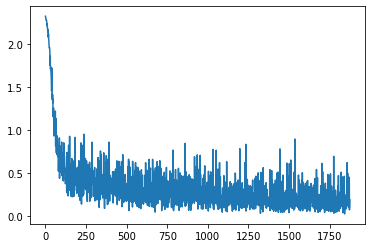

In [8]:
net = SimpleNet()

losses = train(net, data['train'])
plt.plot(losses)

##Testing The Network##

We trained our network! The loss went down! That's good, right? But how good is our network, exactly?

Well, we can try running our network on a few of our test images and see what happens:

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


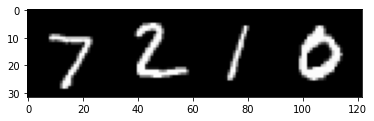

GroundTruth:      7     2     1     0
Predicted:      7     2     1     0


In [9]:
dataiter = iter(data['test'])
images, labels = dataiter.next()
images = images[:4]
labels = labels[:4]

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % data['classes'][labels[j]] for j in range(4)))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % data['classes'][predicted[j]]
                              for j in range(4)))

Pretty good so far. But we also want to be able to test the network on all of our data. Here's a function that can do just that, computing the accuracy on a full set of data:

In [8]:
def accuracy(net, dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
      for batch in dataloader:
          images, labels = batch[0].to(device), batch[1].to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return correct/total

Now we can give it a try:

In [11]:
print("Current accuracy: %f" % accuracy(net, data['train']))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Current accuracy: 0.946517


##Experiments##

Now it's time to poke around a little bit with our models. First I just want this utility function to do window smoothing of data for us. As you may have noticed, we are doing *stochastic* gradient descent, so our losses for each mini-batch can vary quite dramatically. If we smooth them out a little bit they will be easier to look at when we plot them.

In [9]:
def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='same')

###Learning Rate###

Let's experiment around with the learning rate of our model. Changing the learning rate should affect how fast our model converges and how accurate it is. We can see the effect when we plot out the loss function over time for models with different learning rates:

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: 

0.9576 0.9501 0.8935


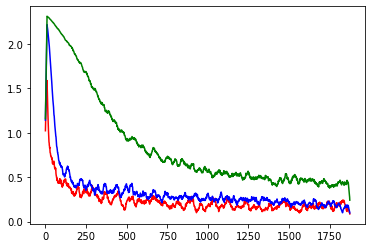

In [39]:
net_high = SimpleNet()
losses_high = train(net_high, data['train'], lr=.1, verbose=0)
acc_high = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'r-')


net_mid = SimpleNet()
losses_mid = train(net_mid, data['train'], lr=.01, verbose=0)
acc_mid = accuracy(net_mid, data['test'])
plt.plot(smooth(losses_mid,20), 'b-')


net_low = SimpleNet()
losses_low = train(net_low, data['train'], lr=.001, verbose=0)
acc_low = accuracy(net_low, data['test'])
plt.plot(smooth(losses_low,20), 'g-')

print(acc_high, acc_mid, acc_low)

###Momentum###

We are using the default value for momentum of `0.9`. Fix your value for the learning rate and try varying the values for momentum.

####**Question 1: What affect does changing the value for momentum have on your model's convergence and final accuracy?**####

Adding momentum is for the acceleration of the model's convergence. According to the plot of losses on different momentum values, using `m = 0.9, 0.8, 0.5` converges faster than using `m = 0.1`. This is reasonable because when `m` approaching to 0, the losses graph becomes similar to the original losses graph without momentum above. The accuracy doesn't differ a lot when using 0.9, 0.8, 0.5 and 0.1 for the momentum. It is about 95% and 96% of accuracy. However, when I tried 0.95 for the momentum, the accuracy decreased to about 87% or 88%. 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


acc1 =  0.8774
acc2 =  0.9552
acc3 =  0.969
acc4 =  0.9631
acc5 =  0.9531


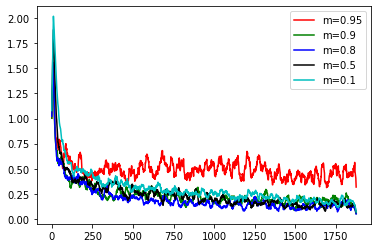

In [14]:
#TODO: Write your code here for experimenting with different values of momentum.
net_1 = SimpleNet()
losses_1 = train(net_1, data['train'], lr=.1, momentum=.95, verbose=0)
acc_1 = accuracy(net_1, data['test'])

net_2 = SimpleNet()
losses_2 = train(net_2, data['train'], lr=.1, momentum=.9, verbose=0)
acc_2 = accuracy(net_2, data['test'])

net_3 = SimpleNet()
losses_3 = train(net_3, data['train'], lr=.1, momentum=.8, verbose=0)
acc_3 = accuracy(net_3, data['test'])

net_4 = SimpleNet()
losses_4 = train(net_4, data['train'], lr=.1, momentum=.5, verbose=0)
acc_4 = accuracy(net_4, data['test'])

net_5 = SimpleNet()
losses_5 = train(net_5, data['train'], lr=.1, momentum=.1, verbose=0)
acc_5 = accuracy(net_5, data['test'])
plt.plot(smooth(losses_1,20), 'r', label='m=0.95')
plt.plot(smooth(losses_2,20), 'g', label='m=0.9')
plt.plot(smooth(losses_3,20), 'b', label='m=0.8')
plt.plot(smooth(losses_4,20), 'k', label='m=0.5')
plt.plot(smooth(losses_5,20), 'c', label='m=0.1')
plt.legend()
print("acc1 = ", acc_1)
print("acc2 = ", acc_2)
print("acc3 = ", acc_3)
print("acc4 = ", acc_4)
print("acc5 = ", acc_5)

###Weight Decay###

Right now we aren't using any weight decay with our model. However, it can be useful as a method of regularization if we are worried about overfitting.

Take your best performing model parameters from above for learning rate and momentum. Fix these parameters as you answer the following questions:

####**Question 2: Is our current model overfit or underfit to our training data? How can you tell?**####

I tried `lr = 0.1` and `momentum = 0.8`, which ended to be the highest testing accuracy above. I think this model is a little bit overfitting because training accuracy is a little higher than the testing accuracy. Overall, I don't think this model is overfitting.

####**Question 3: Try out some different values for weight decay. What effect do they have on model convergence? What about final accuracy? Does this match with what you would have expected? Why or why not?**####

The convergence doesn't change a lot when trying differnt lambda values. This is reasonable because momentum contributes more to the speed of the convergence.
According the weight decay values I experimented below, I found that the training accuracy and the testing accuracy is closet when `lambda = 1e-5` , though the accuracies are not as high as using lower lambda values. The certain thing is that, using larger weight decay may decrease the accuracy of the model. This result is expected because when usig larger weight decay, the model can generalize too much, which may cause underfitting that results in lower accuracy.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train acc =  0.9753
test acc =  0.9686
-------------------
lambda =  1e-06
train acc =  0.9734333333333334
test acc =  0.9681


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


-------------------
lambda =  1e-05
train acc =  0.9644666666666667
test acc =  0.9622


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


-------------------
lambda =  0.001
train acc =  0.9690833333333333
test acc =  0.9622


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


-------------------
lambda =  0.01
train acc =  0.9144166666666667
test acc =  0.9196


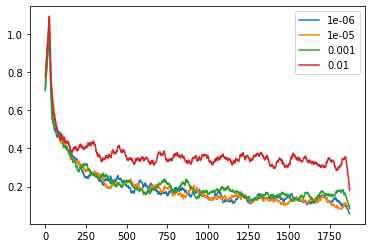

In [17]:
#TODO: Write your code here for experimenting with different weight decay
net_q2 = SimpleNet()
losses_q2 = train(net_q2, data['train'], lr=.1, momentum=0.8, verbose=0)
acc_q2_train = accuracy(net_q2, data['train'])
acc_q2_test = accuracy(net_q2, data['test'])
print("train acc = ", acc_q2_train)
print("test acc = ", acc_q2_test)

decays = [1e-6, 1e-5, 0.001, 0.01]
train_acc_arr = [acc_q2_train]
test_acc_arr = [acc_q2_test]
for lam in decays:
  net_q3 = SimpleNet()
  losses_q3 = train(net_q3, data['train'], lr=.1, momentum=0.8, decay=lam, verbose=0)
  acc_q3_train = accuracy(net_q3, data['train'])
  acc_q3_test = accuracy(net_q3, data['test'])
  train_acc_arr.append(acc_q3_train)
  test_acc_arr.append(acc_q3_test)
  print("-------------------")
  print("lambda = ", lam)
  print("train acc = ", acc_q3_train)
  print("test acc = ", acc_q3_test)
  plt.plot(smooth(losses_q3, 50), label=lam)

# plt.plot(train_acc_arr, 'ro-', label='train acc')
# plt.plot(test_acc_arr, 'go-', label='test acc')
plt.legend()

###A Bigger Model###

Before we used a very simple model but now it's time to try adding some complexity. Create a network that takes as input the 28x28 image, 10 outputs, and any number of layers as long as it has fewer than 2,000,000 connections. Our simple network before had 784\*512 + 512\*10 = 406,528 connections.

Use only fully connected (`nn.Linear`) layers (we'll get to other layer types soon). However, play around with different [activation functions](https://pytorch.org/docs/stable/nn.functional.html#non-linear-activation-functions), [losses](https://pytorch.org/docs/stable/nn.html#loss-functions), and hyperparameter settings. You can also try different training regimes. For example, you could try lowering the learning rate during training by calling our training method twice like this:

    train(net, data['train'], epochs=5, lr=.1)
    train(net, data['train'], epochs=3, lr=.01)
    train(net, data['train'], epochs=2, lr=.001)

Maybe it works better? Why did I choose those particular numbers? Who knows! It's deep learning, no one really knows what will work you have to just try things and see.

Experiment with different network architectures and settings to get the most accurate model.

####**Question 4: Describe your final model architecture. How did you come up with the number of layers and number of neurons at each layer?**####

Originally, I tried 2 hidden layers with 128 neurons for the first hidden layer and 64 neurons for the second one. Both of them using relu as the activation functions and using log softmax for the final layer because this is a classification model. After the trianing using `epochs = 5, lr = 0.01, m = 0.9`, I got about 98% traning accuracy and 97% testing accuracy. 
In order to increase the accuracy, I modified my original nn structure to be 3 hidden layers with 256 neurons for the first hidden layer, 128 for the second one, and 64 for the third one. The number of neurons is just divided by 2 each layer, no any specific reasons. As a result, this new model did improve the training accuracy a little bit (99%), but the testing accuracy is still about 97%.

I increased the number of layers because the model can learn different features in the intermediate layers.

####**Question 5: What hyperparameters did you experiment with? What values were good for them? Do you think your model was over or under fitting the data?**####

Using the new model described in Q4, I tried the combinations of 2 learing rate vlaues and 2 momentum vlaues. The best result turns out to be the training model with `lr = 0.01` and `m = 0.9`. This model has 98.99% training accuracy and 97.75% testing accuracy. The training accuracy is a bit higher than the testing accuracy, which seems a bit overfitting, but I think it is not a big problem.

In [23]:
#TODO: Write your new model and experiments here
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class ExperiNet(nn.Module):
    #TODO: Change all this
    def __init__(self):
        super(ExperiNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.log_softmax(x, dim=1)
        return x

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[1,   100] loss: 2.269
[1,   200] loss: 1.526
[1,   300] loss: 0.680
[1,   400] loss: 0.497
[1,   500] loss: 0.449
[1,   600] loss: 0.336
[1,   700] loss: 0.329
[1,   800] loss: 0.282
[1,   900] loss: 0.266
[1,  1000] loss: 0.248
[1,  1100] loss: 0.231
[1,  1200] loss: 0.223
[1,  1300] loss: 0.206
[1,  1400] loss: 0.212
[1,  1500] loss: 0.182
[1,  1600] loss: 0.175
[1,  1700] loss: 0.163
[1,  1800] loss: 0.184
[2,   100] loss: 0.149
[2,   200] loss: 0.128
[2,   300] loss: 0.133
[2,   400] loss: 0.142
[2,   500] loss: 0.122
[2,   600] loss: 0.119
[2,   700] loss: 0.133
[2,   800] loss: 0.117
[2,   900] loss: 0.108
[2,  1000] loss: 0.123
[2,  1100] loss: 0.110
[2,  1200] loss: 0.104
[2,  1300] loss: 0.102
[2,  1400] loss: 0.099
[2,  1500] loss: 0.118
[2,  1600] loss: 0.118
[2,  1700] loss: 0.119
[2,  1800] loss: 0.128
[3,   100] loss: 0.080
[3,   200] loss: 0.076
[3,   300] loss: 0.083
[3,   400] loss: 0.077
[3,   500] loss: 0.093
[3,   600] loss: 0.081
[3,   700] loss: 0.099
[3,   800] 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Current accuracy: 0.990250
Current accuracy: 0.976600


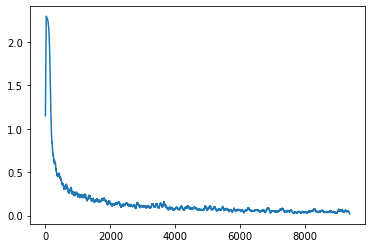

In [24]:
expnet = ExperiNet()

losses_expnet = train(expnet, data['train'], epochs=5, lr=0.01)
plt.plot(smooth(losses_expnet, 50))

print("Current accuracy: %f" % accuracy(expnet, data['train']))
print("Current accuracy: %f" % accuracy(expnet, data['test']))

lr =  0.1 ,  m =  0.9


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Current train accuracy: 0.967783
Current test accuracy: 0.960700
lr =  0.1 ,  m =  0.8


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Current train accuracy: 0.987533
Current test accuracy: 0.975800
lr =  0.01 ,  m =  0.9


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Current train accuracy: 0.989983
Current test accuracy: 0.977500
lr =  0.01 ,  m =  0.8


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Current train accuracy: 0.987000
Current test accuracy: 0.977100


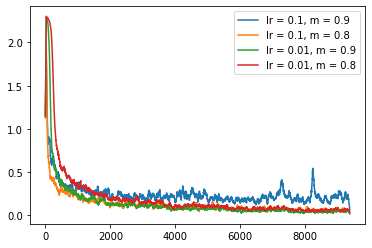

In [25]:
lr_arr = [0.1, 0.01]
m_arr = [0.9, 0.8]
for lr in lr_arr:
  for m in m_arr:
    print("lr = ", lr, ", ", "m = ", m)
    expnet = ExperiNet()
    losses_expnet = train(expnet, data['train'], epochs=5, lr=lr, momentum=m, verbose=0)
    label = "lr = " + str(lr) + ", " + "m = "+ str(m)
    plt.plot(smooth(losses_expnet, 50), label=label)
    print("Current train accuracy: %f" % accuracy(expnet, data['train']))
    print("Current test accuracy: %f" % accuracy(expnet, data['test']))

plt.legend()

##Download and submit!##

Download your iPythorn notebook from Colab to your `hw0` directory. Then follow the instructions to collate and submit your homework.